# Understanding `kelp`

In this notebook, we try to understand the package `kelp` by playing around with some of its functionalities. We will try to find reflected phase curve and thermal phase curve for the WASP-189b planet, recently observed by CHEOPS. We first try to compute the thermal part.

### Total phase curve

A complete phase curves in `kelp`, which include the thermal emission as well as reflected light, are produced as descrribed by [Heng, Morris & Kitzmann (2021)](https://www.nature.com/articles/s41550-021-01444-7) and [Morris et al. (2021)](https://arxiv.org/abs/2110.11837), for reflected and thermal part, respectively. The individual parts are described later in the notebook.

It is known that a phase curve will be dependent on the planet and the filter in which it is being observed. Hence, before jumping into calculting the phase curves, we will create a `planet` object and a `filt` object for storing planetary and passband properties. One can directly take values of planetary parameters for various planets stored by default using `Planet.from_name` method. However, this does not contain all of the exoplanets, well, for obvious reasons. That's why we shall manually define the planetary properties. The same goes for filter, if a required filter is not available in `Filter.from_name` method, one can manually create one. Fortunately, the CHEOPS passband is available so, we will use it here.

We will use the planetary properties of WASP-189 from [Lendl et al. (2021)](https://doi.org/10.1051/0004-6361/202038677) and [Deline et al. (2022)](https://arxiv.org/abs/2201.04518).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from kelp import Planet, Filter, Model

In [2]:
# Needed planetary parameters
per=2.7240330
t0=2458926.5416960
inc=84.03
rp=0.069577
ecc=0.
a=4.60
u=[0.414, 0.155]
fp=9.65e-5
t_secondary=2458927.9037125
T_s=8000.
rp_a=0.015168

In [3]:
## Creating a Planet Object
plan = Planet(per=per,\
     t0=t0,\
     inc=inc,\
     rp=rp,\
     ecc=ecc,\
     w=None,\
     a=a,\
     u=u,\
     fp=fp,\
     t_secondary=t_secondary,\
     T_s=T_s,\
     rp_a=rp_a, limb_dark='quadratic', name='WASP-189')

fltr = Filter.from_name('CHEOPS')

In [4]:
cml = [[0.],[0., 0.18, 0.]]
# Defining the model
model = Model(hotspot_offset=-0.12043, alpha=0.6, A_B=0., omega_drag=4.5, C_ml=cml, lmax=1, planet=plan, filt=fltr)

The total phase curve would be,

Geometric albedo is:  0.0
Integral phase function:  1.6365516668528062


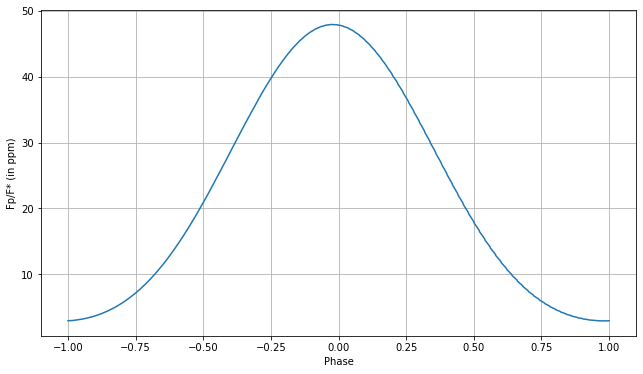

In [5]:
# Phases of the orbit, 0. corresponds to the eclipse, while -1. and 1. to the transits
xi = np.linspace(-np.pi, np.pi, 1000)
ome1 = 0.
g1 = 0.
pc_tot, ag_tot, q_tot = model.phase_curve(xi=xi, omega=ome1, g=g1)

print('Geometric albedo is: ', ag_tot)
print('Integral phase function: ', q_tot)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, pc_tot.flux)
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()

On the top of this, we can add an eclipse model from `batman`.

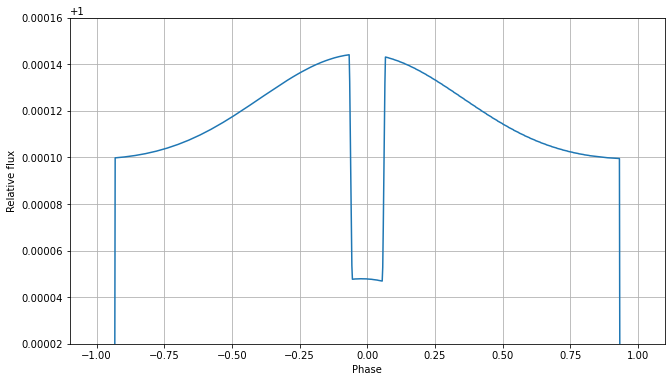

In [6]:
pars = batman.TransitParams()
pars.t0 = -np.pi
pars.per = 2.#per
pars.rp = rp
pars.a = a
pars.inc = inc
pars.ecc = ecc
pars.w = 90.
pars.limb_dark = 'quadratic'
pars.u = u
pars.fp = fp
pars.t_secondary = 0.

m1 = batman.TransitModel(pars, xi/np.pi, transittype='secondary')
m2 = batman.TransitModel(pars, xi/np.pi)
flx_ecl = m1.light_curve(pars)
flx_tra = m2.light_curve(pars)

flx_both = flx_ecl*flx_tra

tot_flx = flx_ecl*pc_tot.flux/1e6
plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, flx_both + (pc_tot.flux/1e6))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
plt.ylim([1.00002, 1.00016])
plt.grid()

### Thermal phase curve

We can first generate a temperature map from this model.

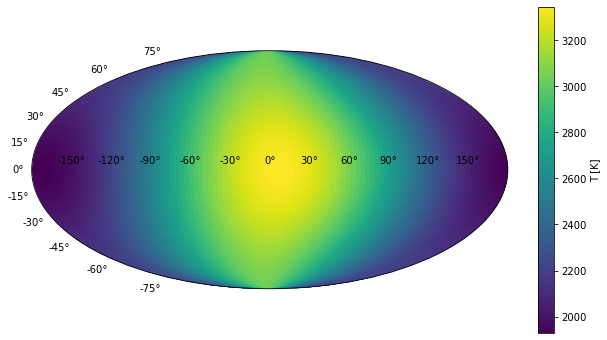

In [7]:
T, theta, phi = model.temperature_map(200, 200, f=2**-0.5)

# Plot the temperature map
fig = plt.figure(figsize=(16/1.5,9/1.5))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.pcolormesh(phi, theta - np.pi/2, T, shading='auto')
plt.colorbar(cax, label='T [K]')
plt.show()

And, using the above temperature map, one can produce the thermal phase curve as follows.

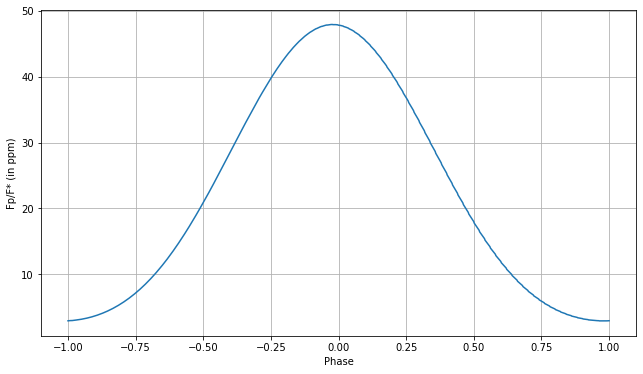

In [8]:
pc_the = model.thermal_phase_curve(xi, n_theta=200, n_phi=200)

plt.figure(figsize=(16/1.5, 9/1.5))
#plt.plot(xi/np.pi, flx_both + (pc_the.flux/1e6))
plt.plot(xi/np.pi, pc_the.flux)
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
#plt.ylim([1.00002, 1.00016])
plt.grid()

And a complete phase curve looks like,

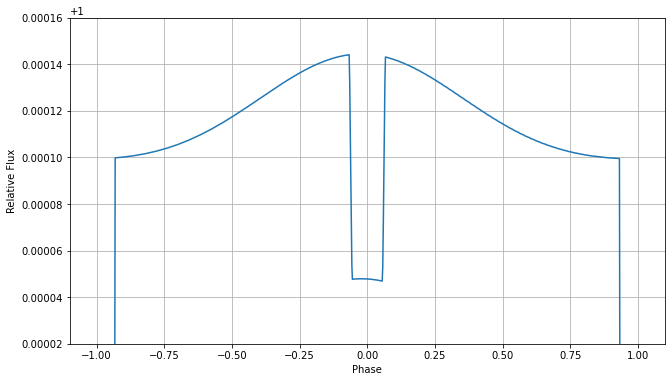

In [9]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, flx_both + (pc_the.flux/1e6))
plt.xlabel('Phase')
plt.ylabel('Relative Flux')
plt.ylim([1.00002, 1.00016])
plt.grid()

### Reflection phase curve

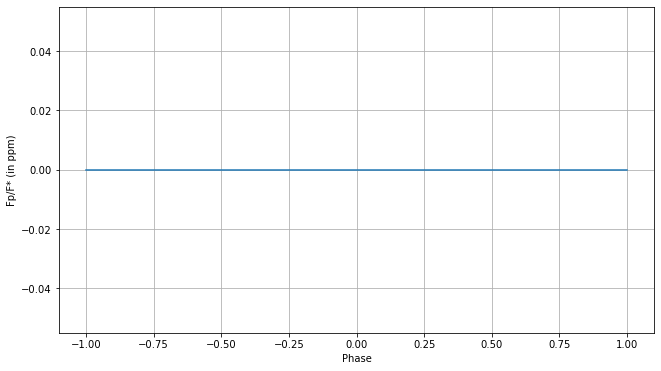

In [10]:
pc_ref, ag_ref, q_ref = model.reflected_phase_curve(xi=xi, omega=ome1, g=g1)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, pc_ref.flux)
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()

Ahh.. I see, so, if we set the single scattering albedo `omega` to zero, then we would get zero reflection, as is expected. However, this is an extreme case, its value should vary between 0. and 1. In that case, we would see non-zero reflected phase curve, as we have shown below.

Geometric albedo is:  0.04581407018001122
Integral phase function:  1.6199982772786


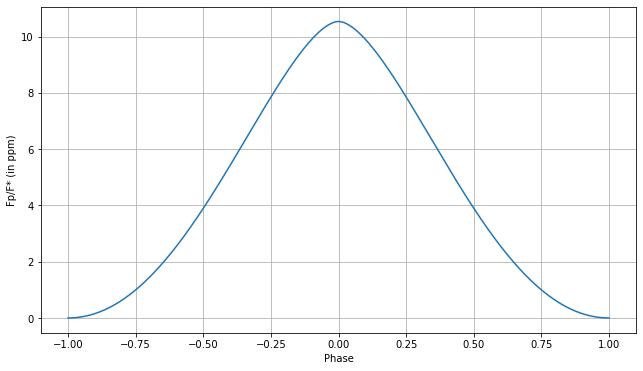

In [11]:
pc_ref1, ag_ref1, q_ref1 = model.reflected_phase_curve(xi=xi, omega=0.3, g=g1)

print('Geometric albedo is: ', ag_ref1)
print('Integral phase function: ', q_ref1)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, pc_ref1.flux)
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()

Now, along with planetary transit and eclipse signals...

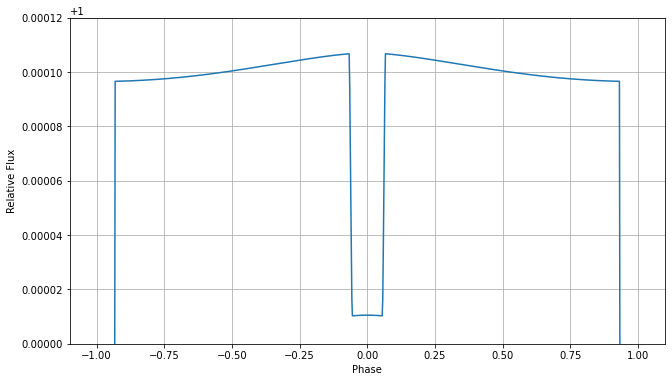

In [12]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, flx_both + (pc_ref1.flux/1e6))
plt.xlabel('Phase')
plt.ylabel('Relative Flux')
plt.ylim([1.0000, 1.00012])
plt.grid()

For this new simulation, we can compare the contribution from the thermal as well as reflection light curves.

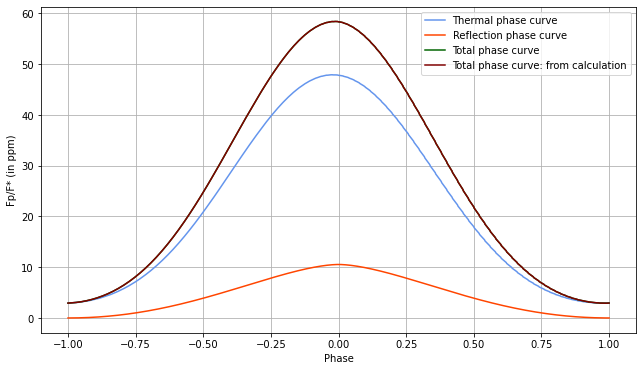

In [13]:
pc_the1 = model.thermal_phase_curve(xi, n_theta=200, n_phi=200)
pc_tot1, ag_tot1, q_tot1 = model.phase_curve(xi=xi, omega=0.3, g=g1)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, pc_the1.flux, c='cornflowerblue', label='Thermal phase curve')
plt.plot(xi/np.pi, pc_ref1.flux, c='orangered', label='Reflection phase curve')
plt.plot(xi/np.pi, pc_tot1.flux, c='darkgreen', label='Total phase curve')
plt.plot(xi/np.pi, pc_ref1.flux+pc_the1.flux, c='maroon', label='Total phase curve: from calculation')
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()
plt.legend()

Few things can be noted from here: Reflection phase curves goes to zero at phase of -1. and 1. This is a consequence of the fact that, since at those phases we are seeing transits -- meaning the nightside, we are not expected to see any reflection.

Total phase curve computed from summing the thermal and reflection phase curves and that returned with the use of function `phase_curve` are the same. So, to avoide writing many things, I would recommend to use the later option.

### Effect of the Bond albedo (A_B) on the phase curves

In the examples given above, we were using a zero Bond albedo (`A_B` = 0.) -- what would change if we make that change? Let's find out.

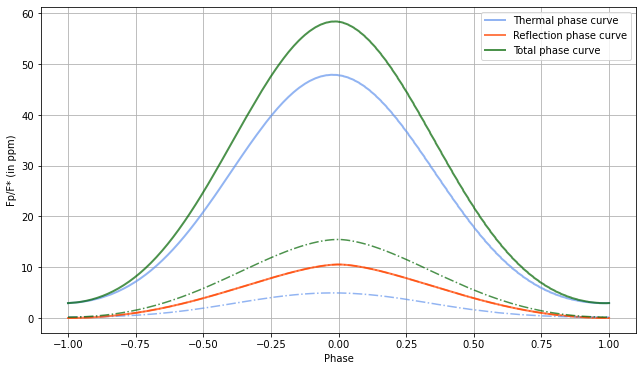

In [14]:
model2 = Model(hotspot_offset=-0.12043, alpha=0.6, A_B=0.7, omega_drag=4.5, C_ml=cml, lmax=1, planet=plan, filt=fltr)
pc_ref2, _, _ = model2.reflected_phase_curve(xi, omega=0.3, g=g1)
pc_the2 = model2.thermal_phase_curve(xi, n_theta=200, n_phi=200)
pc_tot2, _, _ = model2.phase_curve(xi, omega=0.3, g=g1)

plt.figure(figsize=(16/1.5, 9/1.5))

plt.plot(xi/np.pi, pc_the1.flux, c='cornflowerblue',lw=2, label='Thermal phase curve', alpha=0.7)
plt.plot(xi/np.pi, pc_ref1.flux, c='orangered', lw=2, label='Reflection phase curve', alpha=0.7)
plt.plot(xi/np.pi, pc_tot1.flux, c='darkgreen', lw=2, label='Total phase curve', alpha=0.7)

plt.plot(xi/np.pi, pc_the2.flux, c='cornflowerblue', ls='-.', alpha=0.7)
plt.plot(xi/np.pi, pc_ref2.flux, c='orangered', ls='-.', alpha=0.7)
plt.plot(xi/np.pi, pc_tot2.flux, c='darkgreen', ls='-.', alpha=0.7)

plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()
plt.legend()

This means that Bond albedo will affect the thermal emission of the planet (well, that's how the Bond albedo is defined). Let's see how the thermal phase curve changes with Bond albedo.

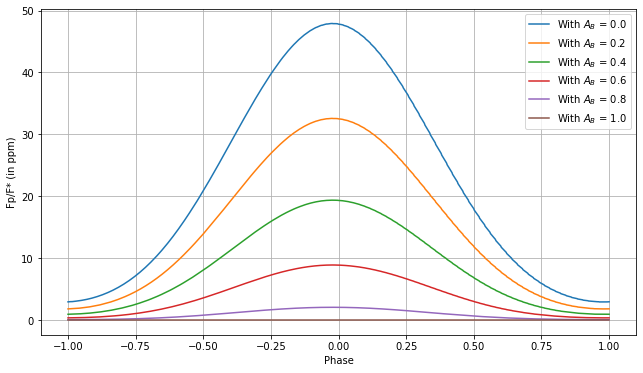

In [15]:
abs1 = np.arange(0., 1.2, 0.2)

plt.figure(figsize=(16/1.5, 9/1.5))

for i in range(len(abs1)):
    model5 = Model(hotspot_offset=-0.12043, alpha=0.6, A_B=abs1[i], omega_drag=4.5, C_ml=cml, lmax=1, planet=plan, filt=fltr)
    pc_the5 = model5.thermal_phase_curve(xi, n_theta=200, n_phi=200)
    plt.plot(xi/np.pi, pc_the5.flux, label=r'With $A_B$ = ' + str(np.around(abs1[i], 1)))

plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')
plt.grid()
plt.legend()

Well, the Bond albedo gives the fraction of light incident on the planet scattered back to the space. Meaning if the Bond albedo is 1. then all energy is reflected to the space, and thus, the planet won't be able to emit anything hence a zero thermal emission. Vice versa the zero Bond albedo is realised when the planet absorbs everything giving the maximum thermal emission.